In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil, prod
import matplotlib.pyplot as plt
import numpy as np
import torch

from model import *

np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda:0


# Load Data

In [35]:
%%capture --no-display
# Load data
snapshots = []
for i in range(200):
    binary = open(f'./turbulence_data/vortJP_0000.{str(i).zfill(3)}', 'rb')
    binary.seek(0)
    snap = np.fromfile(binary, dtype='float64', count=128**2).reshape(128, 128)
    snapshots.append(snap)
    
# Format data
snapshots = torch.Tensor(vorticity_snapshots).unsqueeze(1)
snapshots /= snapshots.absolute().max()

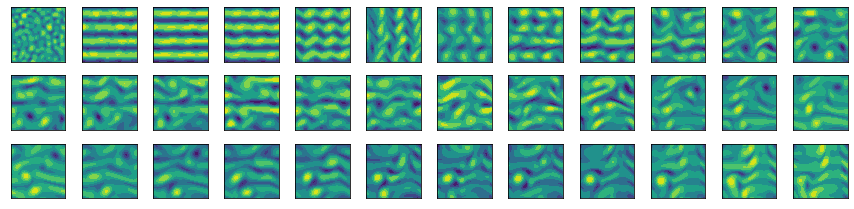

In [36]:
# Visualize select snapshots
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (3, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i][0])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

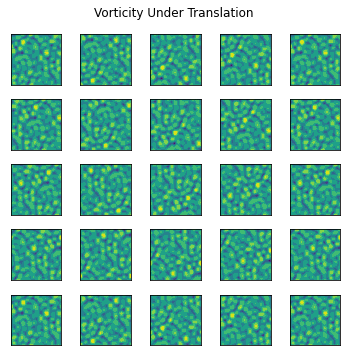

In [48]:
# Translate snapshots
def translate(snapshots, movement_vector, dims=None):
    if dims is None:
        dims = list(range(len(movement_vector)))
    scaled_movement = [int(128 * x / (2 * np.pi)) for x in movement_vector]
    return torch.roll(snapshots, scaled_movement, dims=dims)

# Visualize shift
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (5, 5)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    translate_vector = [(np.pi / 2) * x for x in (i % fig_shape[1], i // fig_shape[1])]
    snap = translate(snapshots[0][0], translate_vector)
    ax.contourf(*axis_array, snap)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('; '.join([f'{x:.02f}' for x in translate_vector]))
fig.suptitle('Vorticity Under Translation')
fig.tight_layout()
plt.show()

# Train

In [6]:
epochs = 101
batch_size = 128
epoch_pd = 10

In [7]:
autoencoder = AEModel(embedded_dim=8).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=.001)
criterion = nn.MSELoss()

In [8]:
autoencoder.train()
batches = ceil(len(snapshots) / batch_size)
for epoch in range(epochs):
    for _ in range(batches):
        batch = snapshots[np.random.choice(range(len(snapshots)), batch_size)].to(device)
        _, logits = autoencoder(batch)
        loss = criterion(logits, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % epoch_pd == 0:
        print(f'Epoch: {epoch} \tLoss:{float(loss.detach())}')

Epoch: 0 	Loss:0.039833128452301025


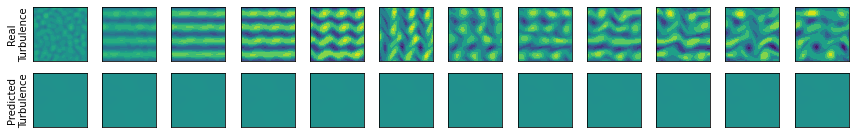

In [9]:
# Preview reconstruction
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (2, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(fig_shape[1]):
    # Actual
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Real\nTurbulence')
    
    # Predicted
    ax = fig.add_subplot(*fig_shape, fig_shape[1]+i+1)
    ax.contourf(*axis_array, autoencoder(snapshots[[i]].to(device))[1].detach().cpu()[0, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Predicted\nTurbulence')
fig.tight_layout()
plt.show()

# Eigenanalysis

In [63]:
# Construct shift operator
n = 2
alpha = 2*np.pi/n
omega = snapshots[:10]
omega_prime = translate(omega, (alpha, 0), dims=(2, 3))
E, _ = autoencoder(omega.to(device))
E_prime, _ = autoencoder(omega_prime.to(device))
# Should this be done element-wise?
E_plus = torch.linalg.pinv(E)
T = E_prime @ E_plus
fit_quality = (torch.matmul(T, E) - E_prime).absolute().mean()
print(f'Shift operator average error: {fit_quality:.4f}')
print(f'E average value: {E.absolute().mean():.4f}')

# Get eigenvalues
# Lambda_j = np.exp(2*np.pi*np.i*l_j / n)

# Construct basis
# _, V = torch.eig(T, eigenvectors=True)
# _, W = torch.eig(T, eigenvectors=True)
# Q, R = torch.qr(...)

# Solve for each fourier component
l = list(range(4))

Shift operator average error: 0.0012
E average value: 0.0524
